# Airports in Scotland

This project seeks to map the direct internal flight routes between airports in Scotland. Then, there will be some analysis to find which airports are most critical to Scotland's air infrastructure.

Note: Data from Oban Airport to Coll and Colonsay has been left out of the dataset.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import list of nodes
airports = pd.read_csv("ListOfAirportsAndAirfields.csv")
airports.head()

,id,airport,latitude,longitude
0,0,Aberdeen International Airport,57.2037,-2.2005
1,1,Edinburgh Airport,55.9474,-3.3614
2,2,Glasgow Airport,55.8699,-4.4326
3,3,Glasgow Prestwick Airport,55.5112,-4.5911
4,4,Oban Airport,56.4655,-5.3983


In [2]:
# import list of edges
edges = pd.read_csv("FlightRoutes.csv")
edges.head()

,departure,destination
0,0,11
1,0,13
2,0,15
3,1,13
4,1,12


## Data cleaning and formatting

In [3]:
airports.dtypes

id             int64
airport       object
latitude     float64
longitude    float64
dtype: object

Let's make sure the airports are stored as categorical data.

In [4]:
airports["airport"] = airports["airport"].astype("category")

In [5]:
edges.dtypes

departure      int64
destination    int64
dtype: object

Now let's replace all the numerical identifiers with the names of the airports in our edges list.

## Create Network

In [6]:
# create graph
G = nx.Graph()
for i, node in airports.iterrows():
    G.add_node(node["id"], pos=(node["longitude"], node["latitude"]))

# add edges to graph
all_edges = {}
for i, edge in edges.iterrows():
    G.add_edge(edge["departure"], edge["destination"])
    #all_edges[(edge["departure"], edge["destination"])] = edge["departure"]+"<-->"+edge["destination"]

## Generate Network Map

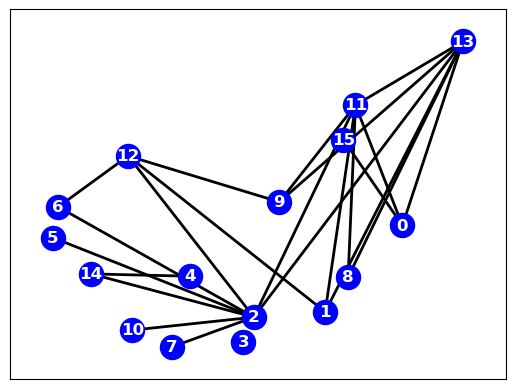

In [7]:
# draw the network
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="blue", alpha=1)
nx.draw_networkx_labels(G, pos, font_color="white", font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black", width=2, arrows=False)

## Plot against a map of Scotland

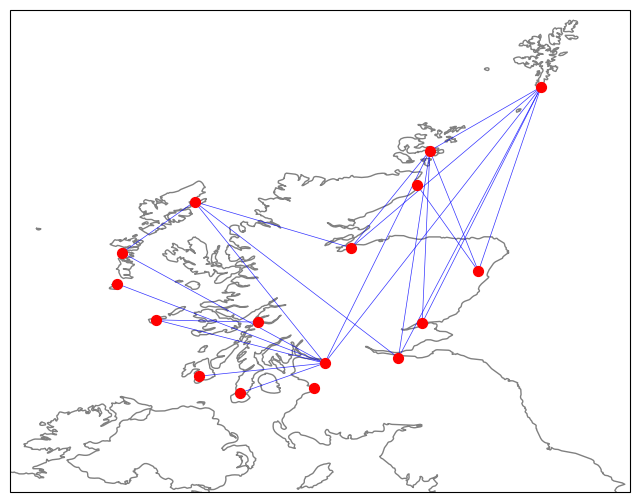

In [8]:
# plot map and points
mapProjection = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection=mapProjection)
ax.set_extent([-9, 0, 54, 61], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
ax.add_feature(cfeature.BORDERS, edgecolor="grey")
#ax.gridlines()

ax.scatter(x=airports.longitude, y=airports.latitude, color="red", s=50, alpha=1, zorder=3,transform=ccrs.PlateCarree())

# plot connections
for u, v in G.edges():
    lon1, lat1 = pos[u]
    lon2, lat2 = pos[v]

    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="blue",
        linewidth=0.5,
        alpha=0.8,
        transform=ccrs.Geodetic(),
        zorder=2
    )

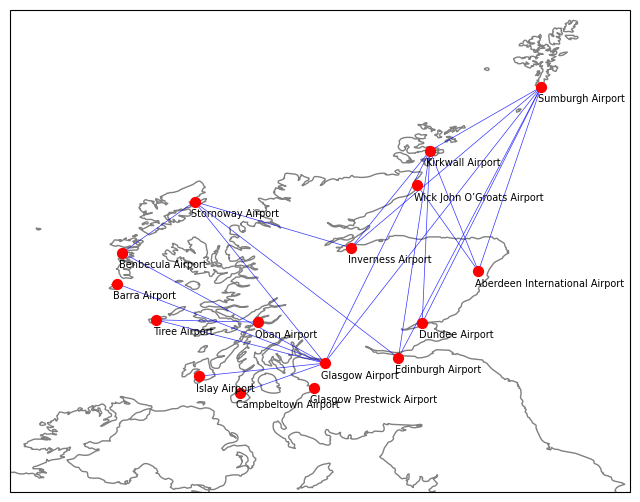

In [9]:
# plot with the names of the airports

mapProjection = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection=mapProjection)
ax.set_extent([-9, 0, 54, 61], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
ax.add_feature(cfeature.BORDERS, edgecolor="grey")
#ax.gridlines()

ax.scatter(x=airports.longitude, y=airports.latitude, color="red", s=50, alpha=1, zorder=3,transform=ccrs.PlateCarree())

# plot labels
for _, row in airports.iterrows():
    ax.text(
        row["longitude"] - 0.05,
        row["latitude"] - 0.25,
        row["airport"],
        transform=ccrs.PlateCarree(),
        fontsize=7,
        ha="left",
        va="bottom",
        zorder=4
    )


# plot connections
for u, v in G.edges():
    lon1, lat1 = pos[u]
    lon2, lat2 = pos[v]

    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="blue",
        linewidth=0.5,
        alpha=0.8,
        transform=ccrs.Geodetic(),
        zorder=2
    )

## Centrality measures for different airports in Scotland
Centrality statistics can be used to message each node's (airport's) importance in the network.
- Degree centrality tells us the number of direct connections each airport has. This can inform us about which airports are locally most significant.
- Closeness centrality tells us how efficiently a node can reach every other node. This is perhaps not too useful in a network about a country the size of Scotland, since individuals may opt to travel by car or train to react locations most efficiently.
- Betweenness centrality tells us how often a node lies on the shortest path between other nodes. This may be important in a Scottish context, since some islands are quite isolated and the only route from these islands to major population centre may require going through another airport.

Let's create a table showing the degree and betweenness centrality scores for the different airports in Scotland.

In [10]:
airportNames = airports.airport
degreeCentrality = [i for i in nx.degree_centrality(G).values()]
betweennessCentrality = [i for i in nx.betweenness_centrality(G).values()]

data = {"airport":airportNames, "degreeCentrality":degreeCentrality, "betweenessCentrality":betweennessCentrality}
centrality = pd.DataFrame(data=data)

print(centrality)

                           airport  degreeCentrality  betweenessCentrality
0   Aberdeen International Airport          0.200000              0.123810
1                Edinburgh Airport          0.200000              0.015873
2                  Glasgow Airport          0.533333              0.577778
3        Glasgow Prestwick Airport          0.000000              0.000000
4                     Oban Airport          0.066667              0.000000
5                    Barra Airport          0.066667              0.000000
6                Benbecula Airport          0.133333              0.000000
7              Campbeltown Airport          0.066667              0.000000
8                   Dundee Airport          0.133333              0.000000
9                Inverness Airport          0.200000              0.015873
10                   Islay Airport          0.066667              0.000000
11                Kirkwall Airport          0.400000              0.193651
12               Stornowa

Here we can see that the airports with the greatest degree centrality are Glasgow Airport (0.53), Kirkwall Airport (0.40), and Sumburgh Airport (0.40). We can see on the map that these airports do ideed have the most direct connections to other airports, meaning they are locally quite important - connecting islands to the mainland.

We can also see that the airport with by far the greatest betweenness centrality is Glasgow (0.58). Aberdeen (0.12), Kirkwall (0.19), Sumburgh (0.19) and Tiree (0.12) are also mildly important in terms of betweenness centrality. This means Glasgow Airport is the most critical point in Scotland's airport infrastructure. If trying to travel, for instance, between Oban Airport and Inverness Airport you would have to pass through Glasgow Airport. Since there is currently no alternative, if flights were disrupted at Glasgow Airport it could affect the whole country's air network. For this reason, it would make sense to route some flights through another airport. However, making such changes would likely be limited by cost.